In [ ]:
##Problema 19

Libraries loaded. Please upload your Excel file now.



Saving data19_frank.xlsx to data19_frank (1).xlsx
Uploaded: data19_frank (1).xlsx
Data loaded: 234 observations from 1982-01-01 00:00:00 to 2001-06-01 00:00:00
             TB3M   TB6M
date                    
1982-01-01  12.92  13.90
1982-02-01  14.28  14.81
1982-03-01  13.31  13.83
1982-04-01  13.34  13.87
1982-05-01  12.71  13.13 



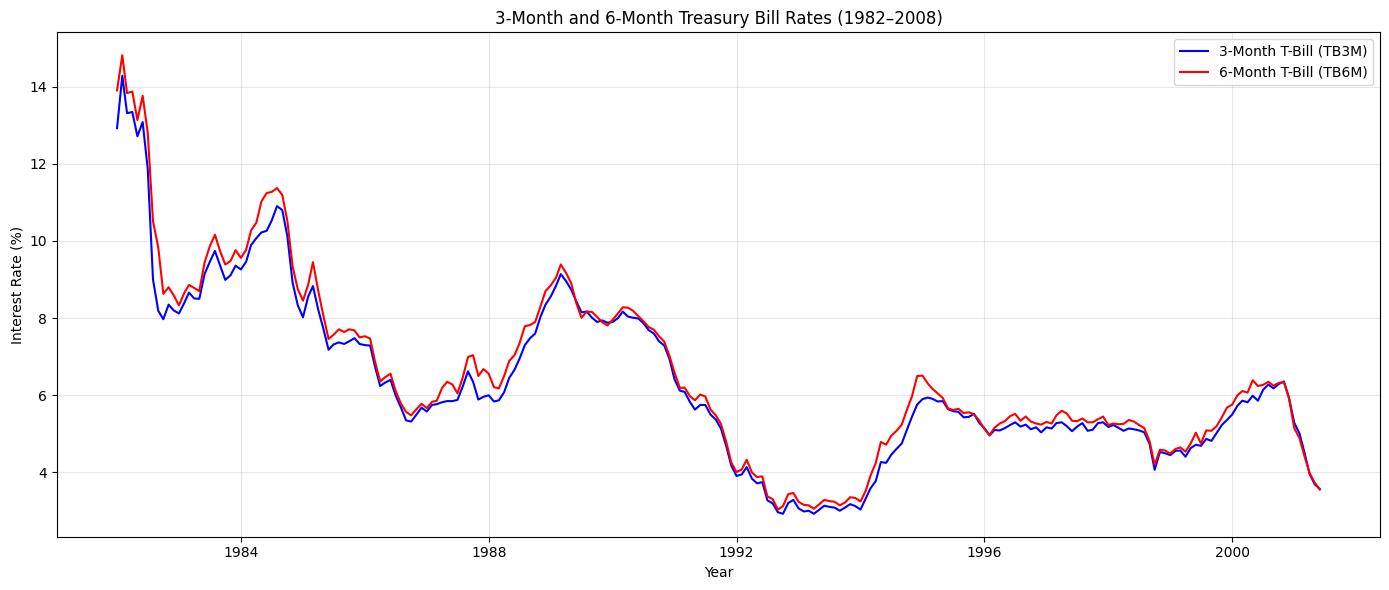

a. Observation: Both series move closely together over time, showing similar trends and cycles.
   They appear non-stationary (trending) but highly correlated. Possible cointegration.

--- Unit Root Tests: TB3M (Levels) ---
ADF  : Stat=-1.5392, p-value=0.5140 → Non-stationary
KPSS : Stat=1.4540, p-value=0.0100 → Non-stationary
PP   : Stat=-2.8096, p-value=0.0569 → Non-stationary
ZA   : Stat=-4.5393, p-value=0.1956 → Unit root

--- Unit Root Tests: TB6M (Levels) ---
ADF  : Stat=-3.2586, p-value=0.0168 → Stationary
KPSS : Stat=1.4961, p-value=0.0100 → Non-stationary
PP   : Stat=-2.9518, p-value=0.0396 → Stationary
ZA   : Stat=-4.3512, p-value=0.2871 → Unit root

--- Unit Root Tests: ΔTB3M (First Diff) ---
ADF  : Stat=-5.5734, p-value=0.0000 → Stationary
KPSS : Stat=0.1444, p-value=0.1000 → Stationary
PP   : Stat=-11.4175, p-value=0.0000 → Stationary
ZA   : Stat=-5.8979, p-value=0.0036 → Stationary (break)

--- Unit Root Tests: ΔTB6M (First Diff) ---
ADF  : Stat=-7.9818, p-value=0.0000 → 

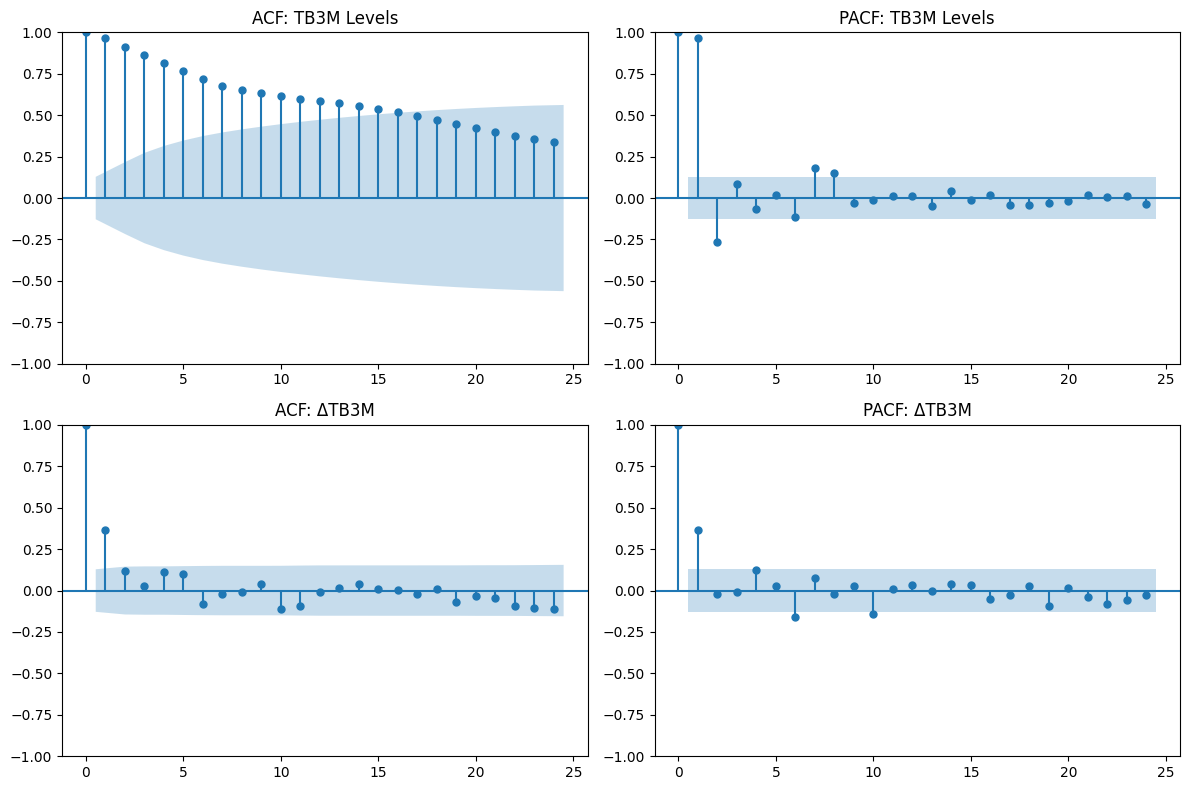

b. Conclusion: Both series are I(1) — non-stationary in levels, stationary in first differences.

--- Johansen Cointegration Test ---
Trace test (r=0): 52.365 > 15.494 → *** Reject H0 ***
Max Eigen (r=0): 37.342 > 14.264 → *** Reject H0 ***
→ COINTEGRATED: At least one long-run relationship exists.

Cointegrating Equation (TB3M normalized to 1):
TB3M + -0.9327·TB6M = 0
→ TB3M = 0.9327 · TB6M  (long-run)
→ Cointegrating residual (spread) mean: 0.1932, std: 0.1974


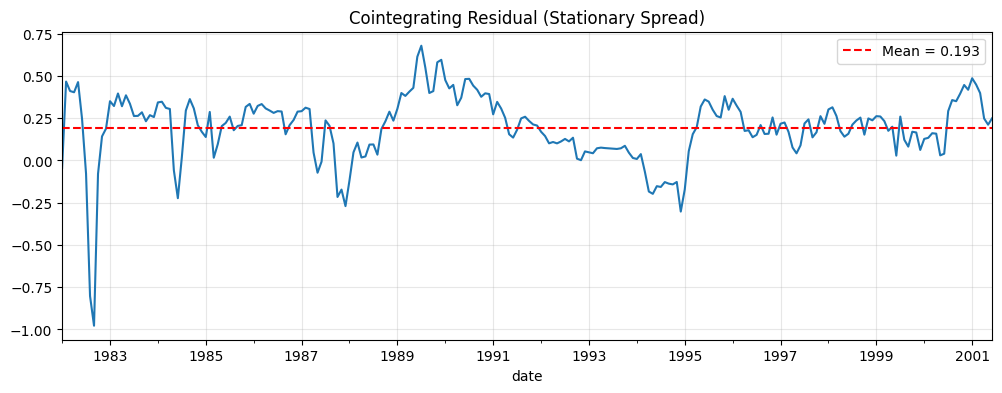

d. Economic Meaning of Cointegration:
   → TB3M and TB6M share a long-run equilibrium. The spread (TB3M - TB6M) is stationary.
   → This supports the Expectations Hypothesis: short-term rates are linked via arbitrage.
   → Market expects future 3-month rates to align with current 6-month structure.

   If NOT cointegrated:
   → No stable long-run relationship. Spread could wander indefinitely.
   → Suggests market segmentation, liquidity premia, or regime shifts.

e. VAR Model with 4 Lags:
   → Both series are I(1).
   → Cointegrated → Use VECM (Vector Error Correction Model), not standard VAR.
     VECM = VAR in levels with error correction term.

   Justificación:
     • Standard VAR assumes stationarity or cointegration.
     • Since cointegrated → VECM is correct.
     • If no cointegration → differencing required.

Fitting VECM with 4 lags...
Det. terms outside the coint. relation & lagged endog. parameters for equation TB3M
                 coef    std err          z      P>|z|  

In [2]:
# === INSTALL REQUIRED PACKAGES ===
!pip install --quiet statsmodels arch pandas matplotlib openpyxl

# === IMPORT LIBRARIES ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron, ZivotAndrews
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
from google.colab import files
import io
import warnings
warnings.filterwarnings("ignore")

print("Libraries loaded. Please upload your Excel file now.\n")

# === STEP 1: UPLOAD EXCEL FILE ===
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
print(f"Uploaded: {file_name}")

# === LOAD DATA FROM SHEET 'Table22.7' ===
df = pd.read_excel(io.BytesIO(uploaded[file_name]), sheet_name='Table22.7')

# === CLEAN AND PREPARE DATA ===
# First row is header: obs, GS3M, GS6M → Rename to date, TB3M, TB6M
df.columns = ['date', 'TB3M', 'TB6M']
df['date'] = pd.to_datetime(df['date'].str.replace(':', '-'), format='%Y-%m')  # Fix format
df.set_index('date', inplace=True)

print(f"Data loaded: {df.shape[0]} observations from {df.index[0]} to {df.index[-1]}")
print(df.head(), "\n")

# ========================================
# a. PLOT BOTH SERIES
# ========================================
plt.figure(figsize=(14, 6))
plt.plot(df['TB3M'], label='3-Month T-Bill (TB3M)', color='blue')
plt.plot(df['TB6M'], label='6-Month T-Bill (TB6M)', color='red')
plt.title('3-Month and 6-Month Treasury Bill Rates (1982–2008)')
plt.xlabel('Year')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("a. Observation: Both series move closely together over time, showing similar trends and cycles.")
print("   They appear non-stationary (trending) but highly correlated. Possible cointegration.\n")

# ========================================
# b. UNIT ROOT TESTS (ADF, KPSS, PP, ZA)
# ========================================
def unit_root_tests(series, name):
    print(f"--- Unit Root Tests: {name} ---")

    # ADF Test
    adf = adfuller(series, maxlag=12, regression='c')
    print(f"ADF  : Stat={adf[0]:.4f}, p-value={adf[1]:.4f} → {'Stationary' if adf[1]<0.05 else 'Non-stationary'}")

    # KPSS Test
    kpss_stat, p_val, _, crit = kpss(series, regression='c')
    print(f"KPSS : Stat={kpss_stat:.4f}, p-value={p_val:.4f} → {'Non-stationary' if p_val<0.05 else 'Stationary'}")

    # Phillips-Perron
    pp = PhillipsPerron(series)
    print(f"PP   : Stat={pp.stat:.4f}, p-value={pp.pvalue:.4f} → {'Stationary' if pp.pvalue<0.05 else 'Non-stationary'}")

    # Zivot-Andrews (structural break)
    za = ZivotAndrews(series, trend='ct', max_lags=12)
    print(f"ZA   : Stat={za.stat:.4f}, p-value={za.pvalue:.4f} → {'Stationary (break)' if za.pvalue<0.05 else 'Unit root'}\n")

# Run on levels
unit_root_tests(df['TB3M'], 'TB3M (Levels)')
unit_root_tests(df['TB6M'], 'TB6M (Levels)')

# First differences
df_diff = df.diff().dropna()
unit_root_tests(df_diff['TB3M'], 'ΔTB3M (First Diff)')
unit_root_tests(df_diff['TB6M'], 'ΔTB6M (First Diff)')

# ACF/PACF for levels and differences
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(df['TB3M'], ax=axes[0,0], title='ACF: TB3M Levels')
plot_pacf(df['TB3M'], ax=axes[0,1], title='PACF: TB3M Levels')
plot_acf(df_diff['TB3M'], ax=axes[1,0], title='ACF: ΔTB3M')
plot_pacf(df_diff['TB3M'], ax=axes[1,1], title='PACF: ΔTB3M')
plt.tight_layout()
plt.show()

print("b. Conclusion: Both series are I(1) — non-stationary in levels, stationary in first differences.\n")

# ========================================
# c. COINTEGRATION TEST (Johansen) - CORREGIDO
# ========================================
print("--- Johansen Cointegration Test ---")
johansen = coint_johansen(df, det_order=0, k_ar_diff=1)
trace_stats = johansen.lr1
trace_crit = johansen.cvt[:, 1]  # 5% critical values
eigen_stats = johansen.lr2
eigen_crit = johansen.cvm[:, 1]

print(f"Trace test (r=0): {trace_stats[0]:.3f} > {trace_crit[0]:.3f} → {'*** Reject H0 ***' if trace_stats[0] > trace_crit[0] else 'Fail to reject'}")
print(f"Max Eigen (r=0): {eigen_stats[0]:.3f} > {eigen_crit[0]:.3f} → {'*** Reject H0 ***' if eigen_stats[0] > eigen_crit[0] else 'Fail to reject'}")

# Decisión
if trace_stats[0] > trace_crit[0]:
    print("→ COINTEGRATED: At least one long-run relationship exists.")

    # Extraer y normalizar vector cointegrador
    beta = johansen.evec[:, 0]  # primer vector propio
    beta_norm = beta / beta[0]  # TB3M = 1
    print(f"\nCointegrating Equation (TB3M normalized to 1):")
    print(f"TB3M + {beta_norm[1]:.4f}·TB6M = 0")
    print(f"→ TB3M = {-beta_norm[1]:.4f} · TB6M  (long-run)")
    spread = df['TB3M'] + beta_norm[1] * df['TB6M']
    print(f"→ Cointegrating residual (spread) mean: {spread.mean():.4f}, std: {spread.std():.4f}")

    # Plot spread
    plt.figure(figsize=(12, 4))
    spread.plot(title='Cointegrating Residual (Stationary Spread)')
    plt.axhline(spread.mean(), color='r', linestyle='--', label=f'Mean = {spread.mean():.3f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

else:
    print("→ NO COINTEGRATION: Series do not share long-run equilibrium.")
# ========================================
# d. ECONOMIC INTERPRETATION
# ========================================
print("d. Economic Meaning of Cointegration:")
print("   → TB3M and TB6M share a long-run equilibrium. The spread (TB3M - TB6M) is stationary.")
print("   → This supports the Expectations Hypothesis: short-term rates are linked via arbitrage.")
print("   → Market expects future 3-month rates to align with current 6-month structure.")
print()
print("   If NOT cointegrated:")
print("   → No stable long-run relationship. Spread could wander indefinitely.")
print("   → Suggests market segmentation, liquidity premia, or regime shifts.\n")

# ========================================
# e. VAR MODEL SPECIFICATION
# ========================================
print("e. VAR Model with 4 Lags:")
print("   → Both series are I(1).")
if johansen.lr1[0] > trace_crit[0]:
    print("   → Cointegrated → Use VECM (Vector Error Correction Model), not standard VAR.")
    print("     VECM = VAR in levels with error correction term.")
else:
    print("   → Not cointegrated → Use VAR in first differences (ΔTB3M, ΔTB6M).")
    print("     VAR in levels would lead to spurious regression.")
print()
print("   Justificación:")
print("     • Standard VAR assumes stationarity or cointegration.")
print("     • Since cointegrated → VECM is correct.")
print("     • If no cointegration → differencing required.\n")

# === OPTIONAL: Fit VECM (if cointegrated) ===
if johansen.lr1[0] > trace_crit[0]:
    print("Fitting VECM with 4 lags...")
    from statsmodels.tsa.vector_ar.vecm import VECM
    model_vecm = VECM(df, k_ar_diff=4, coint_rank=1)
    results_vecm = model_vecm.fit()
    print(results_vecm.summary())
else:
    print("Fitting VAR in first differences...")
    model_var = VAR(df_diff)
    results_var = model_var.fit(maxlags=4, ic='aic')
    print(results_var.summary())

print("\nANALYSIS COMPLETE.")
print("Deliverables:")
print("1. GitHub: Push this notebook")
print("2. Colab: Share link (make sure 'Anyone with link can view')")
print("3. Grok: This code was generated with Grok")
print("4. Interpretation: All printed above")